In [115]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [117]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [118]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [119]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
    print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
    print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [120]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [121]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [122]:
def load_data(path, delimiter, start_time, main_col, target_length=-1):
    # remove any leading or trailing 0s based on the main information column    
    data = np.genfromtxt(path, delimiter=delimiter)
    if data.ndim == 1:
        data = data.reshape((data.shape[0],1))
#     print("initial data shape ", data.shape)
#     print("initial first time ", data[0,0])
#     print("initial last time ", data[data.shape[0]-1,0]) 
    tmp = np.trim_zeros(data[:,main_col], trim='b')
    data = data[:tmp.shape[0],:]
    tmp = np.trim_zeros(data[:,main_col], trim='f')
    data = data[data.shape[0] - tmp.shape[0]:,:]
    
    data = data[data[:,0]>=start_time]
    if target_length != -1:
        data = data[data.shape[0]-target_length:,:]
#     print("data shape ", data.shape)
#     print("first time ", data[0,0])
#     print("last time ", data[data.shape[0]-1,0])  
    
    return data

In [123]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 1 at 30% - 10 flows

In [124]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 25


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17902,)
179
[7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 0.0015355821184659074 and in packets 0.002769084450963737
99th percentile in Kbytes 0.012299856501295078 and in packets 0.018469970278072623

Mean delay in us 0.01228465694772726 and 99th percentile delay in us 0.09839885201036062

Background FCT (ms): mean: 394.53234024101636, 99th %: 1111.923219617143

Fanout max QCT (ms): mean: 11.897770383905286, 99th %: 30.784710714558422

Fanout avg QCT (ms): mean: 4.146158019361562, 99th %: 10.421397831152552

Fanout min QCT (ms): mean: 0.631471528228694, 99th %: 2.7600654521360535

Servers in deadline: mean: 9.96598145458608, 99th %: 8.782122905

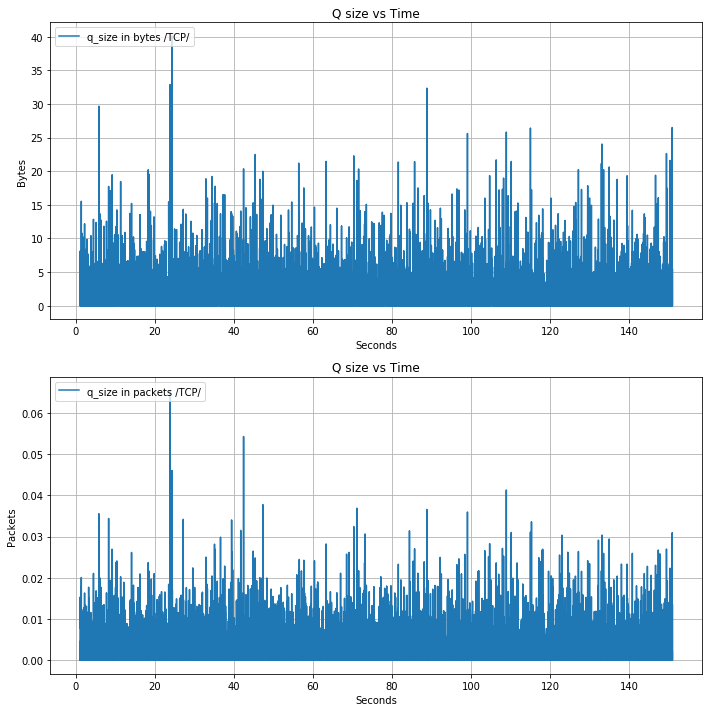

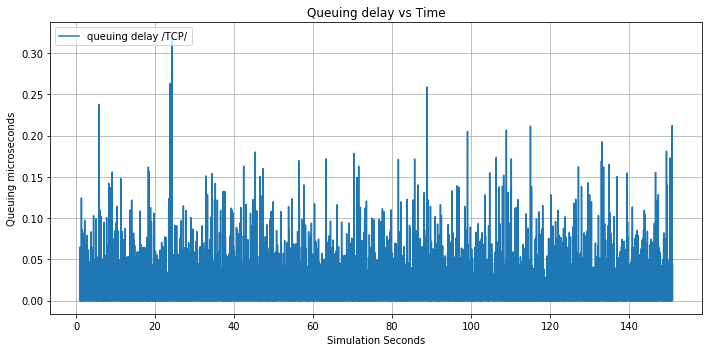

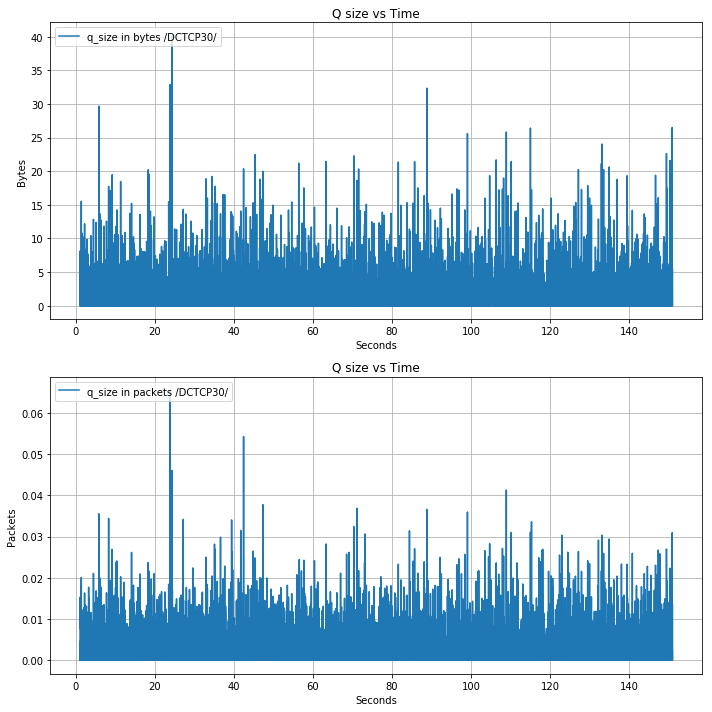

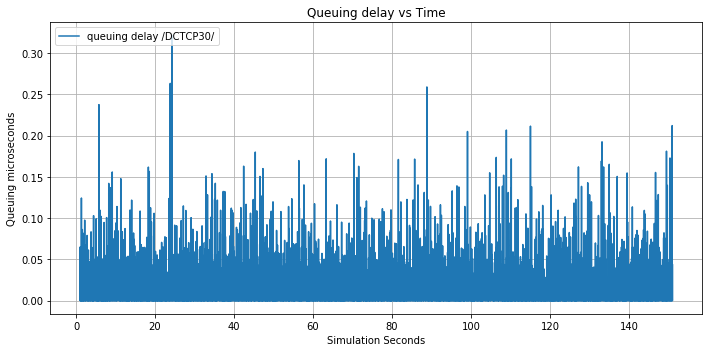

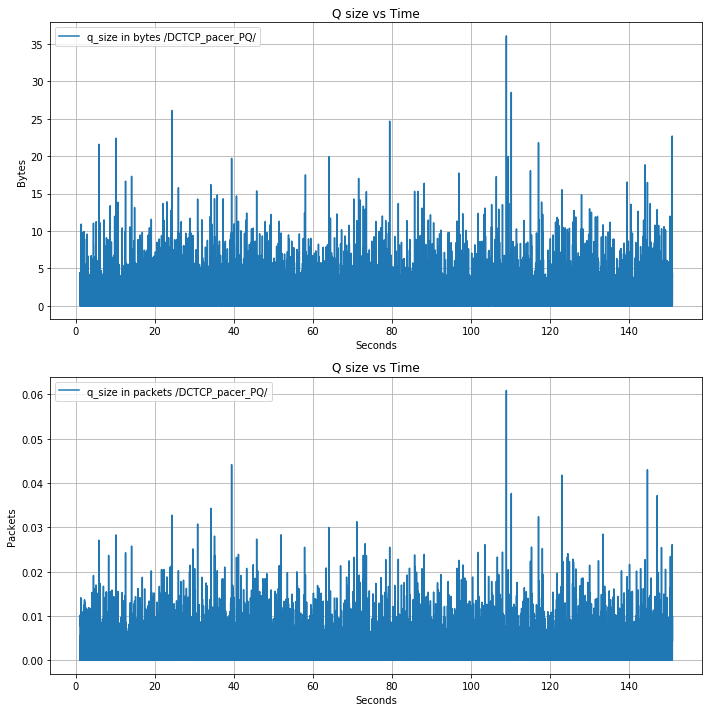

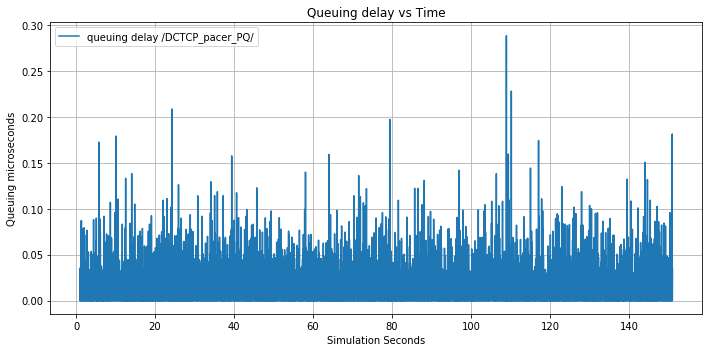

In [125]:
simul_folder = "onlyfanout_wkld1_30_10flows"

stable_state_offset = 0
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    
    """
    (0,1484)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1281)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17186,)
172
[5 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 24.615521035259565 and in packets 25.767947322921835
99th percentile in Kbytes 270.4524389396285 and in packets 283.4821608128959

Mean delay in us 196.92416828207652 and 99th percentile delay in us 2163.619511517028

Background FCT (ms): mean: 103.42237382601735, 99th %: 245.4767942052428

Fanout max QCT (ms): mean: 12.53181863187513, 99th %: 31.61119951007123

Fanout avg QCT (ms): mean: 4.764407789295385, 99th %: 12.444349251694401

Fanout min QCT (ms): mean: 1.1973629218498374, 99th %: 7.09149058507425

Servers in deadline: mean: 9.954905155359013, 99th %: 8.534883720930232

(17186,)
172
[7 7 7 7 

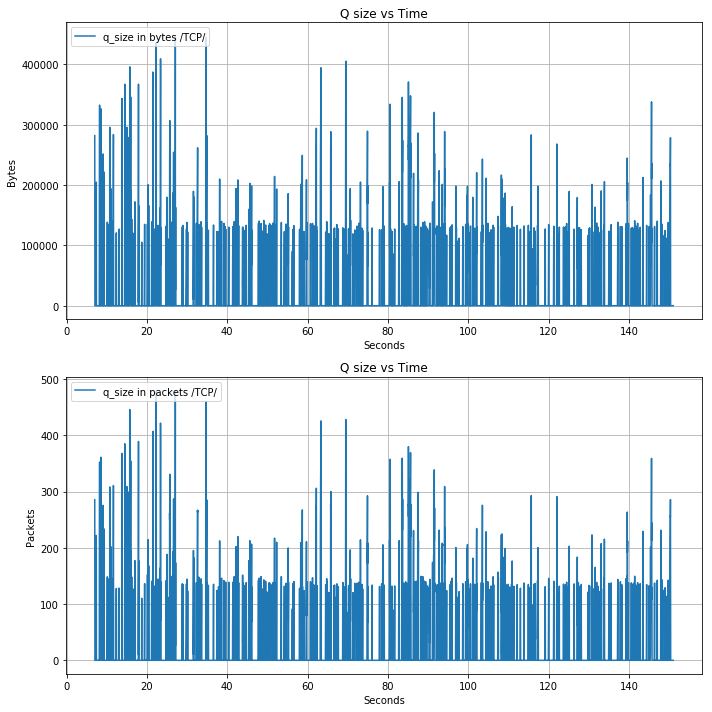

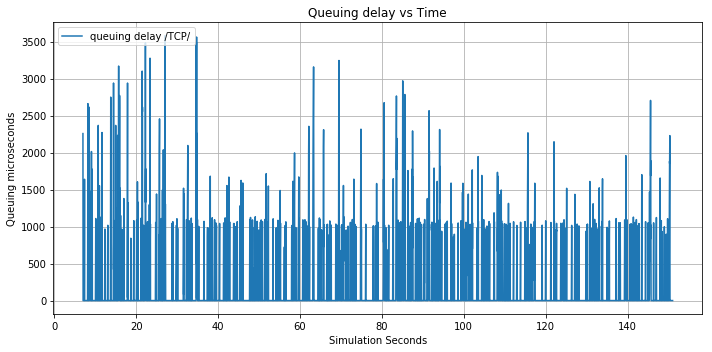

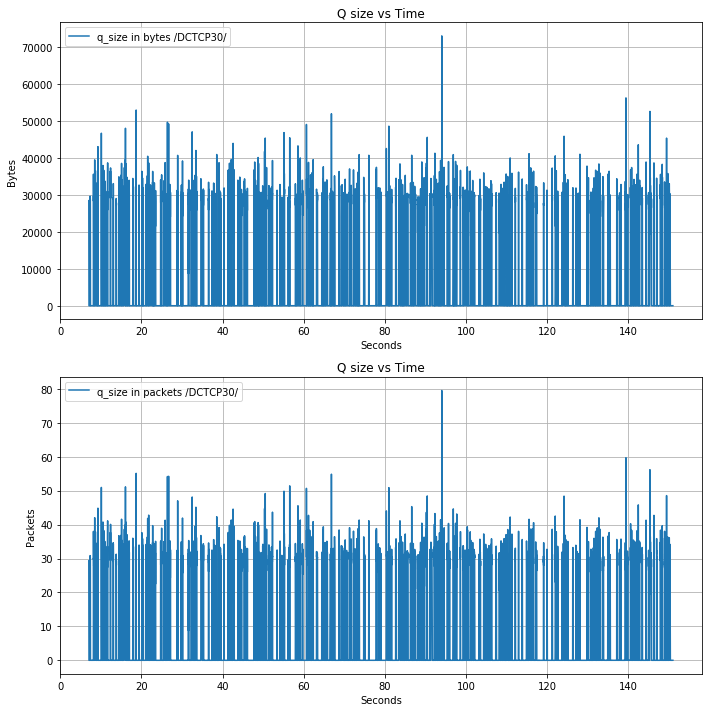

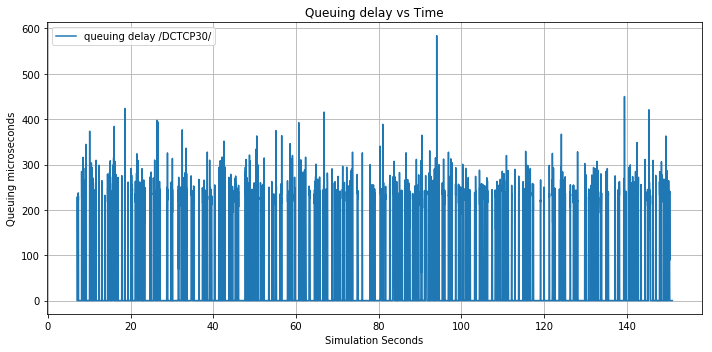

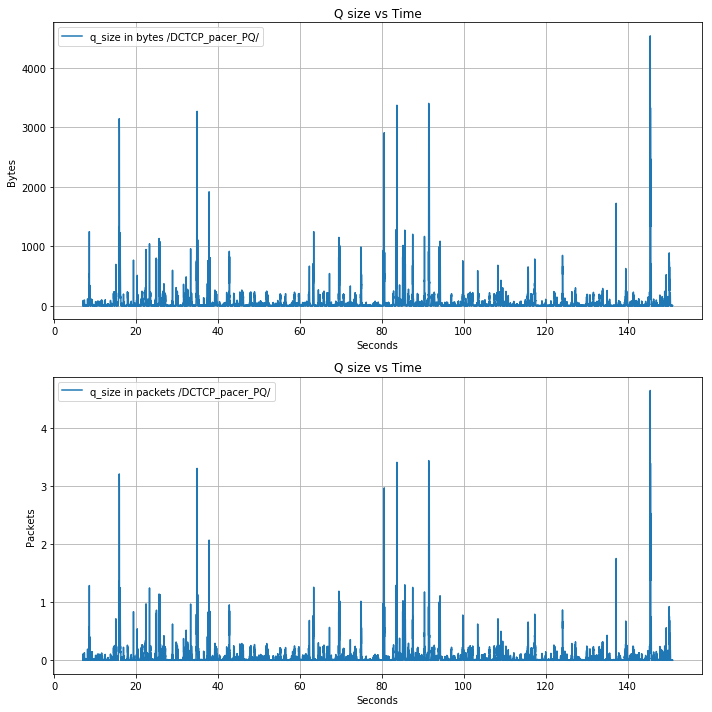

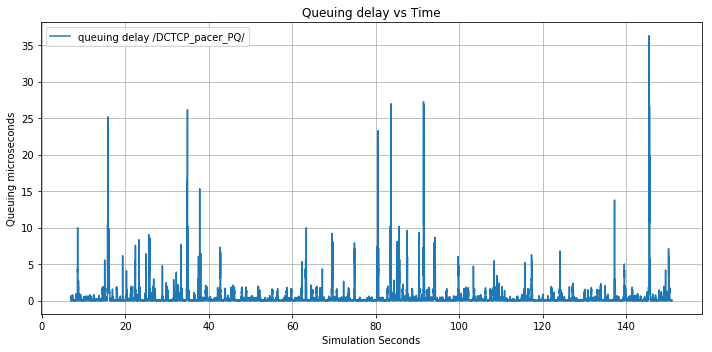

In [126]:
simul_folder = "bkg200_fanout_wkld1_30_10flows"

stable_state_offset = 7
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1695)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,12071)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1396)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,40)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    
    (0,5135)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,35896)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,4273)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,143)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 1 at 30% + background traffic at 400Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17545,)
175
[6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 60.47212507010361 and in packets 63.179613694871406
99th percentile in Kbytes 363.78606950768824 and in packets 381.04814717702595

Mean delay in us 483.77700056082887 and 99th percentile delay in us 2910.288556061506

Background FCT (ms): mean: 131.89453372632016, 99th %: 345.56253383784826

Fanout max QCT (ms): mean: 13.483817300987088, 99th %: 34.44949042465063

Fanout avg QCT (ms): mean: 5.587360407663839, 99th %: 14.781908504821324

Fanout min QCT (ms): mean: 1.9396504580295848, 99th %: 9.078498488029112

Servers in deadline: mean: 9.935423197492163, 99th %: 8.114285714285714

(17545,)
175

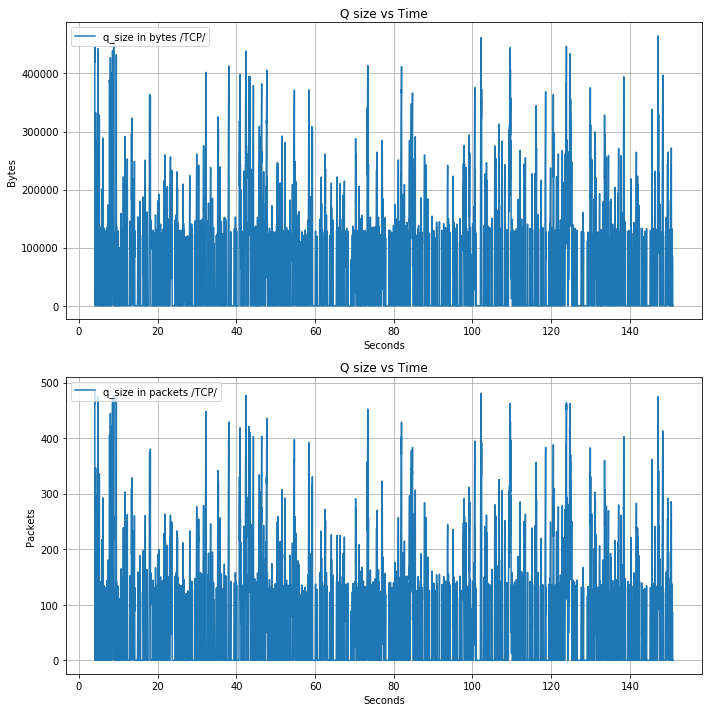

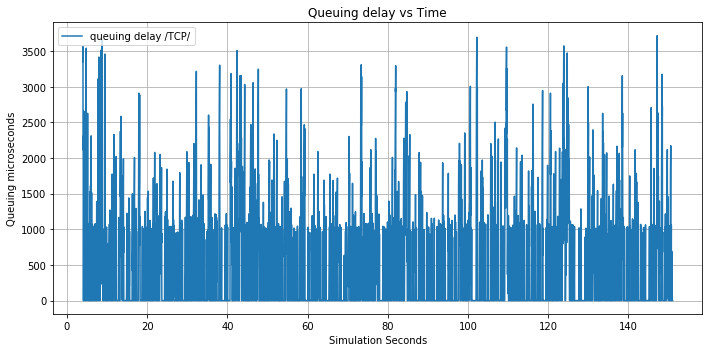

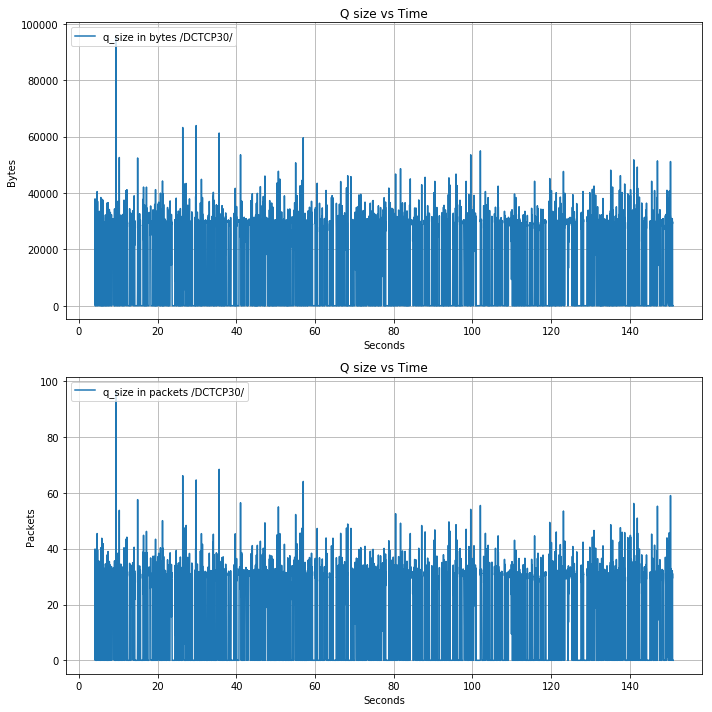

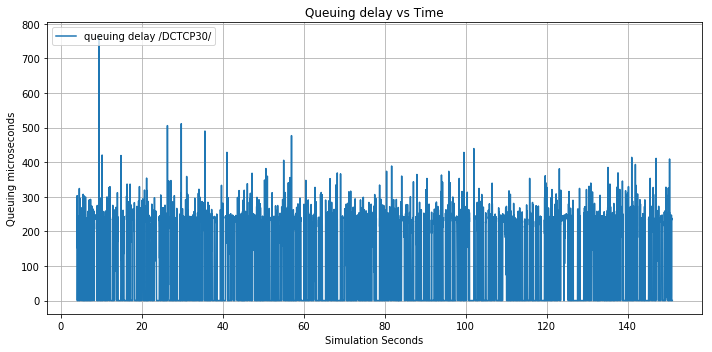

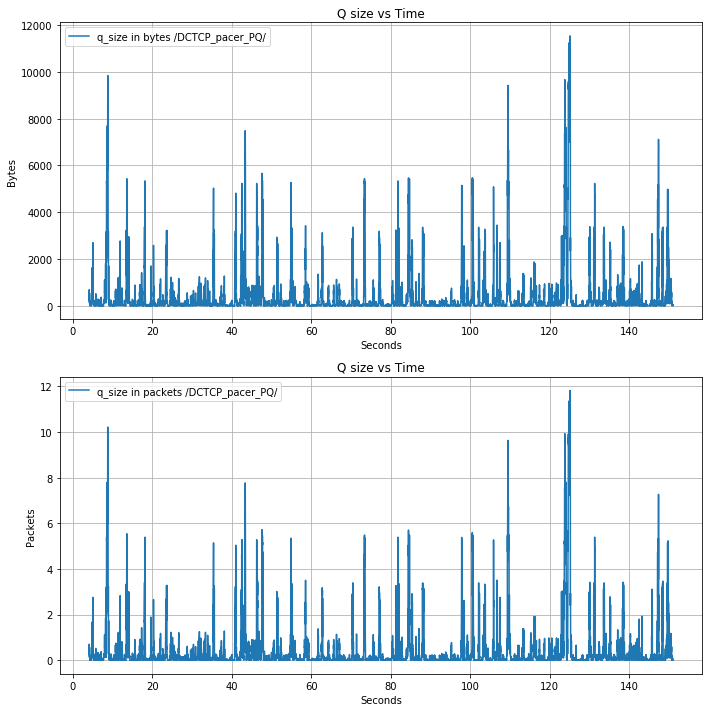

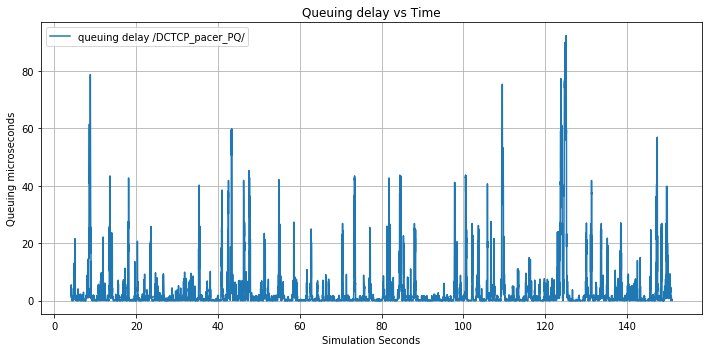

In [127]:
simul_folder = "bkg400_fanout_wkld1_30_10flows"

stable_state_offset = 4
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2128)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,41889)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1680)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,86)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 1 at 30% + background traffic at 600Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17674,)
177
[0 1 1 1 2 2 3 3 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
/TCP/
Mean Q length in Kbytes 121.3627770681355 and in packets 126.93238707324046
99th percentile in Kbytes 432.1194550333768 and in packets 453.3858418496779

Mean delay in us 970.9022165450839 and 99th percentile delay in us 3456.9556402670146

Background FCT (ms): mean: 221.79504751779933, 99th %: 1006.4234372579716

Fanout max QCT (ms): mean: 15.998923704668378, 99th %: 69.83774503888527

Fanout avg QCT (ms): mean: 7.358939776783609, 99th %: 21.755981251302323

Fanout min QCT (ms): mean: 3.4454375921458205, 99th %: 11.931275066629219

Servers in deadline: mean: 9.85934140545434, 99th %: 6.418079096045198

(17674,)
1

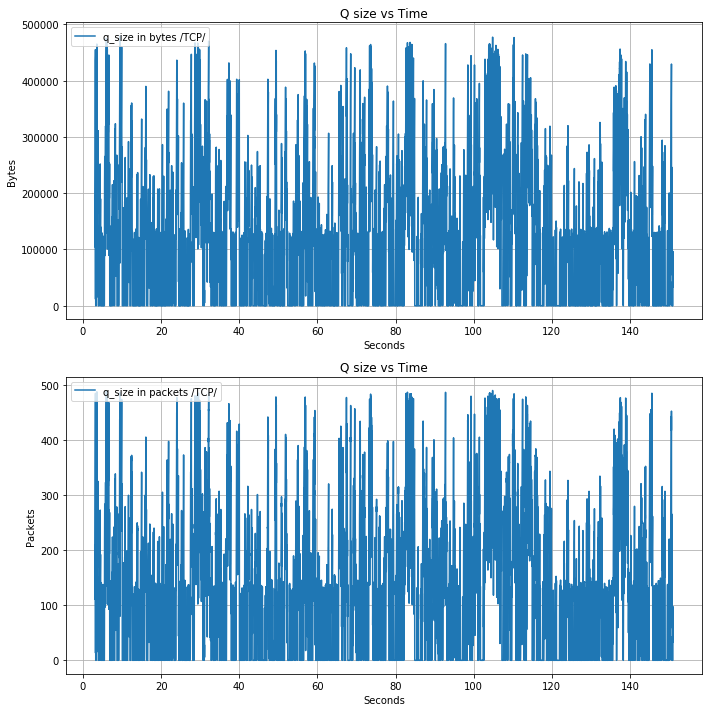

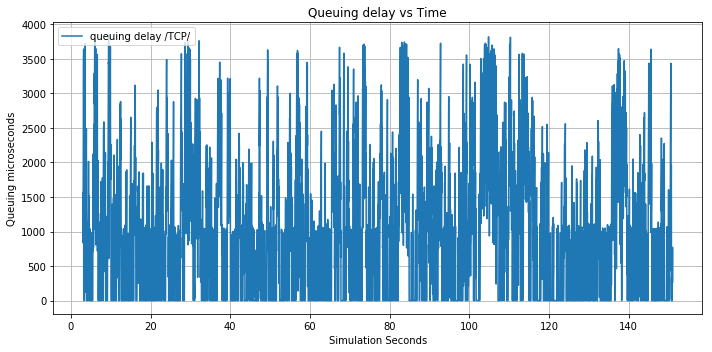

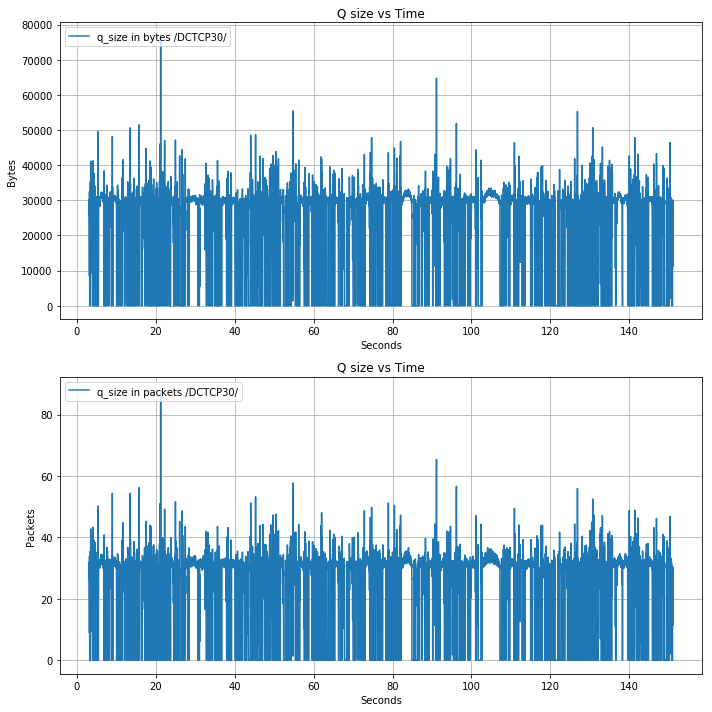

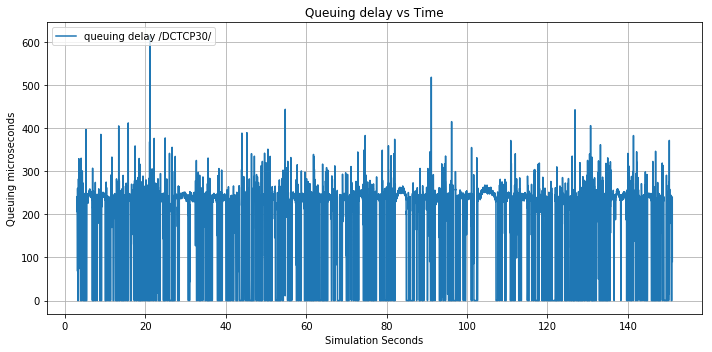

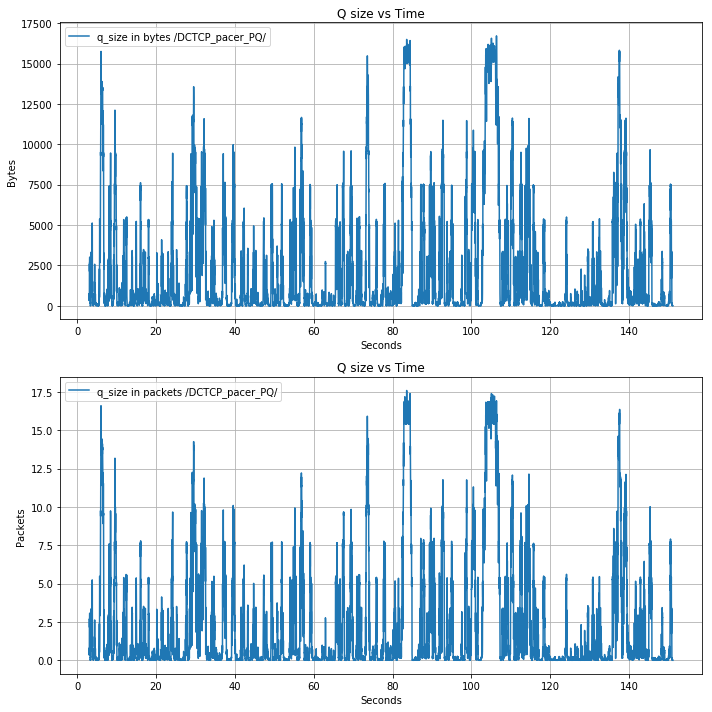

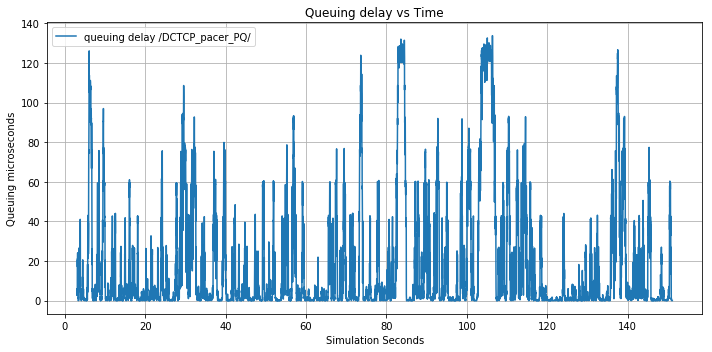

In [128]:
simul_folder = "bkg600_fanout_wkld1_30_10flows"

stable_state_offset = 3
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2553)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90697)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1870)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,94)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

In [129]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(0.01228465694772726, 0.09839885201036062), (196.92416828207652, 2163.619511517028), (483.77700056082887, 2910.288556061506), (970.9022165450839, 3456.9556402670146)], '/DCTCP30/': [(0.01228465694772726, 0.09839885201036062), (48.89381537654204, 279.1046140591429), (99.88321045720689, 294.589893072682), (154.7087386864105, 287.79034528090904)], '/DCTCP_pacer_PQ/': [(0.011414155440468844, 0.08076021362472902), (0.4314846725658412, 6.136778062641597), (3.149323976974814, 44.0655350043576), (17.904554042796878, 124.98243873913542)]}
--------bkg----------
{'/TCP/': [(103.42237382601735, 245.4767942052428), (131.89453372632016, 345.56253383784826), (221.79504751779933, 1006.4234372579716)], '/DCTCP30/': [(106.58669168867571, 248.71424122276838), (140.75093960179262, 358.90593032531433), (245.02052873706785, 1024.5095838664529)], '/DCTCP_pacer_PQ/': [(233.85124381081403, 330.8925996057291), (283.9644948304248, 479.68305026758213), (394.53234024101636, 111

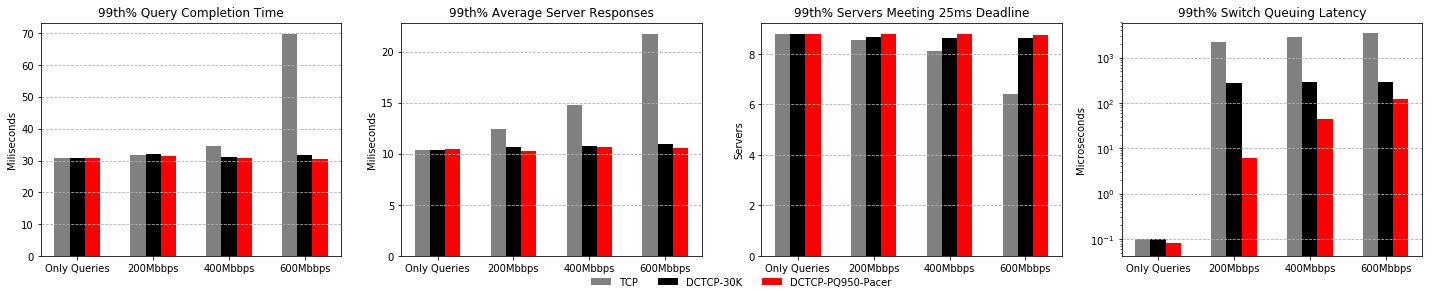

In [130]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
config_num = 4
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('Only Queries', '200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])
p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th% Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")


# qct avg
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_avg[folder]])
p1 = ax2.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax2.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax2.bar(ind+1.5*width, res[2], width, color='r')


ax2.set_title('99th% Average Server Responses')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(x_axis_labels)
ax2.set_ylabel('Miliseconds')
ax2.yaxis.grid(linestyle="--")


# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th% Servers Meeting 25ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")



# Switch Latency
res = []
for folder in results_folders:
    res.append([x[1] for x in latency[folder]])
p1 = ax4.bar(ind-0.5*width, res[0], width, color='grey',log=True)
p2 = ax4.bar(ind+0.5*width, res[1], width, color='k',log=True)
p3 = ax4.bar(ind+1.5*width, res[2], width, color='r',log=True)


ax4.set_title('99th% Switch Queuing Latency')
ax4.set_xticks(ind + width / 2)
ax4.set_xticklabels(x_axis_labels)
ax4.set_ylabel('Microseconds')
ax4.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.41,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()